# Description

Scenario :
* 1 receptor
* Results from DockFlow with PLANTS

Requirements :
* Run DockFlow
* Fill the User Input section of this notebook
* Click on the "Cell" tab, "Run All"

Output :
* Tables
* Bar charts
* RMSD calculations

# User Input

In [1]:
# Path to data
# The notebook should be ran from the working directory folder.
# You can change the path to the summary folder here.
# Default : path = "."
path = "."

In [114]:
# RMSD cutoffs to consider poses as :
# good : close to the crystallographic structure --> between 0.0 and X (excluded) angstroms 
# medium : between X and Y (excluded) angstroms 
# bad : very different from the crystallographic structure : Y to Z (excluded) angstroms

# poses with a RMSD strictly below this value are good
RMSD_good = 2.0
# poses with a RMSD above or equal to the previous limit, and below the following limit are medium
RMSD_medium = 3.0
# poses with a RMSD above or equal to the previous limit, and below the following limit are bad
RMSD_bad = 5.0
# poses with a RMSD above the previous value are discarded 

In [ ]:
# Range of selection of the top X docking poses (sorted by PLANTS score) for the protocol validation

top_list = [1,3,5,10]

In [2]:
# Save folder for tables and graphs
# By default, the save folder will be created inside the work directory
# as "ReportFlow/PLANTS_VS_decoys_enrichment"
# You can change the path and names of the save folder here.
# Default : save_folder = "./PLANTS_docking_rescoring_decoys_actives"
save_folder = "./PLANTS_docking"

# Initialization

In [3]:
# Only show output, hide code.
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
# Import python modules

%matplotlib inline

from matplotlib import rcParams
rcParams['mathtext.default'] = 'tt'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
from sklearn.metrics import auc
import os.path

## Process user input

In [5]:
# Create a list of ligands based on folder name
dockfile_list = ! ls -l {path}/docking/ | awk '/^d/{{print $$9}}'

In [115]:
# Create dictionnary for the RMSD ranges
rmsd_limit = {'good'  : [0.0,RMSD_good],
             'medium' : [RMSD_good,RMSD_medium],
             'bad' : [RMSD_medium,RMSD_bad]}

In [6]:
# Create the save folder
! mkdir -p $save_folder

In [8]:
# Check results available
method_list = []
scores_list = []

# Docking
f = '{}/docking/ranking_sorted.csv'.format(path)
if os.path.isfile(f):  
    scores_list.append('PLANTS')
    print('Results detected : {}'.format(' - '.join(scores_list)))
    
# if docking results don't exist    
else:
    print("ERROR : {}/docking does not contain the ranking_sorted.csv file".format(path))

Results detected : PLANTS


## Create Dataframes

In [12]:
# PLANTS docking results
f = '{}/docking/ranking_sorted.csv'.format(path)
plants_detail = pd.read_csv(f, header=0)
plants_detail.rename(columns = {'TOTAL_SCORE' : 'PLANTS', 'LIGAND_ENTRY' : 'POSE'}, inplace=True)

# Assign ligand name by splitting the pose name
plants_detail = plants_detail.assign(LIGAND = plants_detail.POSE.apply(lambda x: x.split('_')[0]))
# Add rank
plants_detail.reset_index(inplace=True)
plants_detail.rename(columns = {'index' : 'PLANTS_RANK'}, inplace=True)
    
plants = plants_detail[['LIGAND','POSE','PLANTS_RANK','PLANTS']]

In [10]:
# Create actual ligand list
lig_list = plants['LIGAND'].unique().tolist()

In [76]:
# RMSD

reference_folder = ! grep "lig_folder=" {path}/DockFlow.config
reference_folder = reference_folder[0].split('lig_folder="')[1][:-1]
reference_list = ! cd {reference_folder}; ls -v *.mol2

rmsd = pd.DataFrame()

for reference in reference_list:
    ref_file = '{}/{}'.format(reference_folder,reference)
    output_file = '{}/rmsd_{}.csv'.format(reference_folder,reference)
    # Remove old output
    ! rm -f {output_file}
    # Compute with Hungarian Algorithm
    ! RMSDFlow -r {ref_file} -i {path}/docking/lig/*.mol2 -a ha -o {output_file} -s
    # Read
    temp = pd.read_csv(output_file, header=0)
    rmsd = pd.concat([rmsd, temp])

# drop unused columns
rmsd.drop(['Number of atoms read', 'Number of atoms in molecule', 'Reference'], axis=1, inplace=True)

# Add rank by RMSD
rmsd.sort_values('RMSD', inplace=True)
rmsd.reset_index(inplace=True, drop=True)
rmsd.reset_index(inplace=True)
rmsd.rename(columns = {'index' : 'RMSD_RANK'}, inplace=True)
# Rename
rmsd.rename(columns = {'Input' : 'POSE'}, inplace=True)
# Reorganize
rmsd = rmsd[['POSE','RMSD_RANK','RMSD']]

In [128]:
# Match all results

# PLANTS
all_scores = plants.copy()

# RMSD
all_scores = pd.merge(all_scores, rmsd, how='left', on=['POSE'] )

# add state (RMSD below or above the limit)
all_scores = all_scores.assign(DESCRIPTION = all_scores.RMSD.apply(lambda x: 
                                                                   'good' if (x >= rmsd_limit['good'][0] and x < rmsd_limit['good'][1]) 
                                                                   else 'medium' if (x >= rmsd_limit['medium'][0] and x < rmsd_limit['medium'][1])
                                                                   else 'bad' if (x >= rmsd_limit['bad'][0] and x < rmsd_limit['bad'][1])
                                                                  else 'discarded'))
    
# only poses with values
all_subset = all_scores.dropna()

In [129]:
# Melted dataframes

# for score
df_scores = pd.melt(all_scores, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['PLANTS', 'RMSD'], var_name='METHOD', value_name='SCORE')
# for rank
df_rank = pd.melt(all_scores, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['{}_RANK'.format(i) for i in ['PLANTS', 'RMSD']], var_name='METHOD', value_name='RANK')
# rename method to remove "_RANK"
df_rank['METHOD'] = df_rank['METHOD'].apply(lambda x: x.split('_RANK')[0])
df = pd.merge(df_scores, df_rank, how='left', on=['LIGAND','POSE','DESCRIPTION','METHOD'])

# subset only keeping poses with values
# for score
df_scores_subset = pd.melt(all_subset, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['PLANTS', 'RMSD'], var_name='METHOD', value_name='SCORE')
# for rank
df_rank_subset = pd.melt(all_subset, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['{}_RANK'.format(i) for i in ['PLANTS', 'RMSD']], var_name='METHOD', value_name='RANK')
# rename method to remove "_RANK"
df_rank_subset['METHOD'] = df_rank_subset['METHOD'].apply(lambda x: x.split('_RANK')[0])
df_subset = pd.merge(df_scores_subset, df_rank_subset, how='left', on=['LIGAND','POSE','DESCRIPTION','METHOD'])

In [130]:
# Subset of poses with an RMSD below the defined limit

rmsd_good_subset = all_subset.loc[all_subset['RMSD'] <= RMSD_good]

In [204]:
# Count occurencies of RMSD within range for each top range selection

data = []

for description in rmsd_limit:
    for top in top_list:
        temp = all_subset.sort_values('PLANTS')
        occ = len(temp.head(top).loc[ temp['DESCRIPTION'] == description])
        top_string = 'Top {}'.format(top)
        data.append([description,top_string,occ])

occurency = pd.DataFrame(data, columns=['Description','Selection Range', 'Occurency'])

In [132]:
# Color palettes
# Create color palette and dictionnary based on the ligand list for the plots
color_list = sns.husl_palette(len(lig_list),0,0.8,0.65)

# Color list based on state (RMSD below or above the limit)       
state_list = ['good', 'medium','bad','discarded']
state_color_list = ['green','blue','orange','red']

# Create a hatch list for plots based on the method list
hatch_list = ['','/', '\\', '-', '.', '//']
method_hatch_list = [hatch_list[i] for i in range(2)]
method_color_list = [[c for c in sns.color_palette("deep")][i] for i in range(2)]

# Set the new custom color list
sns.set_palette(sns.color_palette('deep'))

# Results

In [133]:
all_scores

,LIGAND,POSE,PLANTS_RANK,PLANTS,RMSD_RANK,RMSD,DESCRIPTION
0,XK2,XK2_entry_00001_conf_01,0,-150.5730,1,0.650163,good
1,XK2,XK2_entry_00001_conf_02,1,-150.4150,0,0.584528,good
2,XK2,XK2_entry_00001_conf_03,2,-112.0210,5,1.465296,good
3,XK2,XK2_entry_00001_conf_04,3,-111.9560,7,1.543130,good
4,XK2,XK2_entry_00001_conf_05,4,-109.9670,13,1.934825,good
5,XK2,XK2_entry_00001_conf_06,5,-109.2770,15,2.803291,medium
6,XK2,XK2_entry_00001_conf_07,6,-108.9950,12,1.902684,good
7,XK2,XK2_entry_00001_conf_08,7,-108.7630,9,1.792930,good
8,XK2,XK2_entry_00001_conf_09,8,-108.1250,8,1.765835,good
9,XK2,XK2_entry_00001_conf_10,9,-106.6970,10,1.823137,good


## Summary

In [134]:
all_scores.describe()

,PLANTS_RANK,PLANTS,RMSD_RANK,RMSD
count,25.000000,25.000000,25.000000,25.000000
mean,12.000000,-106.260184,12.000000,2.128269
std,7.359801,14.647112,7.359801,0.793304
min,0.000000,-150.573000,0.000000,0.584528
25%,6.000000,-108.995000,6.000000,1.473905
50%,12.000000,-105.468000,12.000000,1.902684
75%,18.000000,-97.527500,18.000000,2.860549
max,24.000000,-93.092600,24.000000,3.098733


## Plots

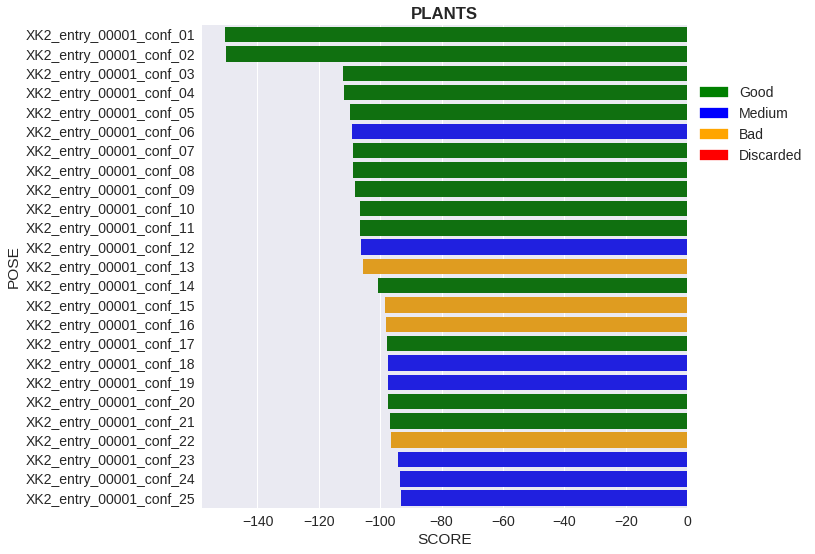

In [166]:
# Sorted barplot colored by RMSD range

def grid_barplot(data,size=15,aspect=3,col_wrap=1):
    aspect = aspect
    size_x = size
    size_y = size_x*aspect
    methods = ['PLANTS']
    num_subplots = 1
    num_cols = col_wrap
    num_rows = num_subplots // num_cols
    num_rows += num_subplots % num_cols
    position = range(1, num_subplots+1)

    fig = plt.figure(figsize=(size_x,size_y))
    for method,v in zip(methods, range(num_subplots)):
        data_subset = data.sort_values(method)
        order = data_subset.POSE.tolist()
        colors = [state_color_list[0] if (x == 'good') 
                  else state_color_list[1] if (x == 'medium') 
                  else state_color_list[2] if (x == 'bad')
                  else state_color_list[3] for x in data_subset.DESCRIPTION]
        ax = fig.add_subplot(num_rows,num_cols,position[v])
        sns.barplot(x=data_subset[method], y=data_subset.POSE, 
                    palette=colors,
                    orient='h', order=order, ax=ax, label=method)
        ax.legend().set_visible(False)
        ax.set_title(method,fontweight='bold')
        ax.set_xlabel('SCORE')

    plt.tight_layout()

grid_barplot(data=all_subset, size=10, aspect=0.8)

#Create custom artists
goodArtist      = plt.Rectangle((0,0),2,1, color=state_color_list[0])
mediumArtist    = plt.Rectangle((0,0),2,1, color=state_color_list[1])
badArtist       = plt.Rectangle((0,0),2,1, color=state_color_list[2])
discardedArtist = plt.Rectangle((0,0),2,1, color=state_color_list[3])

#Create legend from custom artist/label lists
_=plt.legend([goodArtist,mediumArtist,badArtist,discardedArtist],
             ['Good', 'Medium', 'Bad', 'Discarded'], 
             bbox_to_anchor=(1, 0.9), loc='upper left', ncol=1)

plt.savefig('{}/barplot_score_rmsd.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

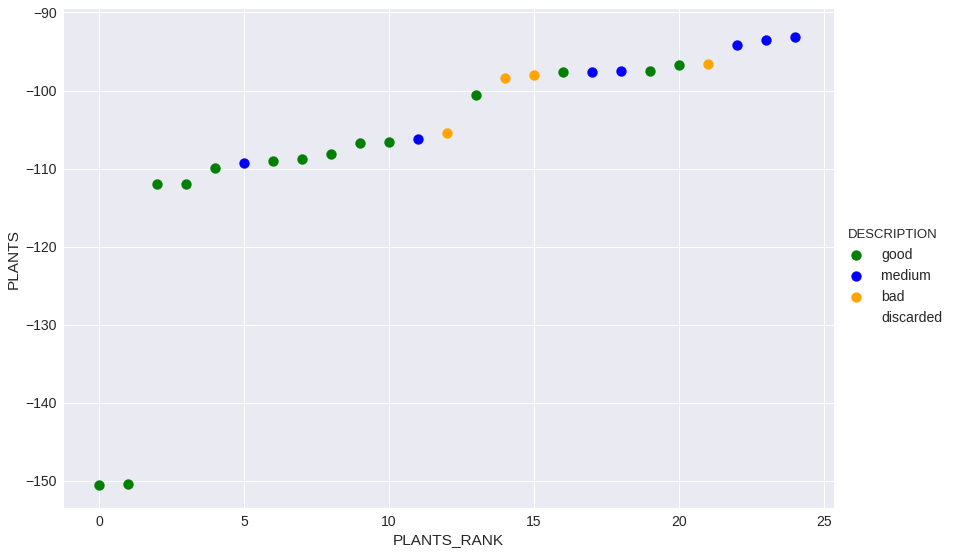

In [169]:
# Scatter plot : score by rank
g = sns.FacetGrid(data=all_subset ,hue='DESCRIPTION', hue_order=state_list, 
                  aspect=1.5, size=8, palette=state_color_list)

g.map(plt.scatter, 'PLANTS_RANK', 'PLANTS', s=100)
g.add_legend()
plt.subplots_adjust(hspace=0.15,wspace=0.1)
            
plt.savefig('{}/scatter_rank_by_score_color_rmsd.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

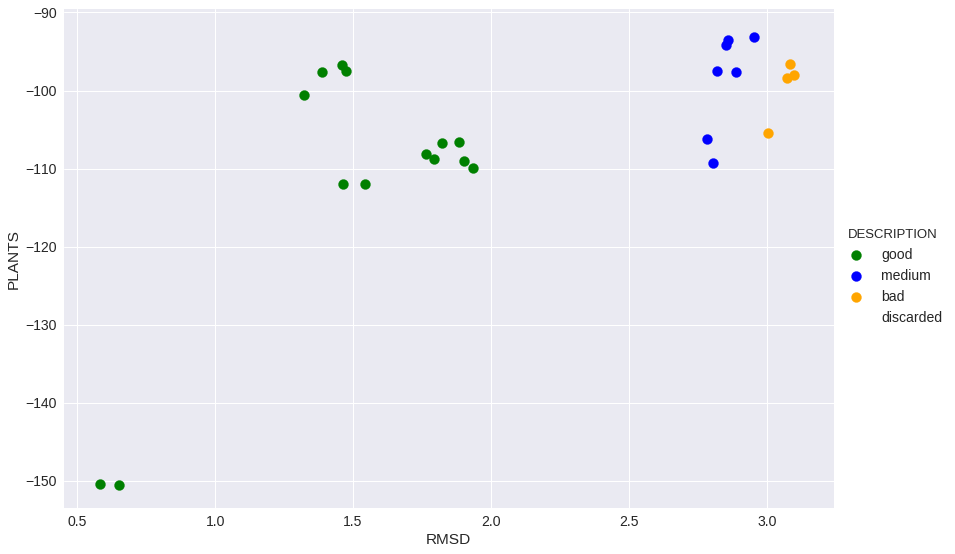

In [168]:
# Score by RMSD

g = sns.FacetGrid(data=all_subset ,hue='DESCRIPTION', hue_order=state_list, 
                  aspect=1.5, size=8, palette=state_color_list)

g.map(plt.scatter, 'RMSD', 'PLANTS', s=100)
_=g.add_legend()

plt.savefig('{}/scatter_score_by_rmsd.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

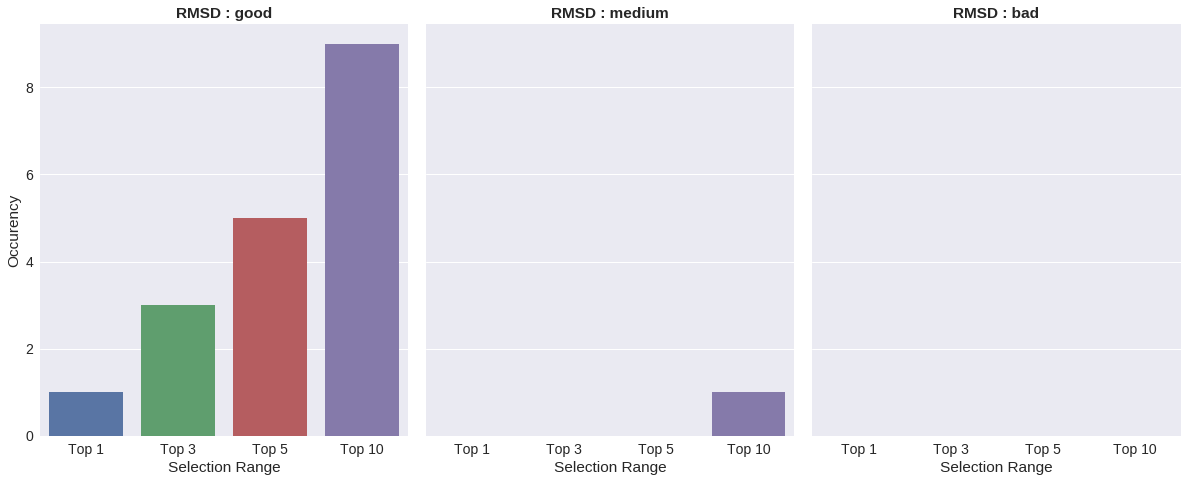

In [206]:
# Barplot occurency of poses with RMSD within range, for different top X range selection

g = sns.factorplot(kind='bar', data=occurency, 
                   x='Selection Range', y='Occurency',
                   col='Description', col_order=['good','medium', 'bad'], col_wrap=3,
                   aspect=0.8, size=7)

_=g.set_titles('RMSD : {col_name}',fontweight='bold')

plt.savefig('{}/barplot_range_selection.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')